## 4.2 Zero-Coupon bond Prcing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

class FractionalVasicekModel:
    """
    Fractional Vasicek Model for Zero-Coupon Bond Pricing using Young Integration
    """
    
    def __init__(self, alpha, mu, sigma, r0):
        self.alpha = alpha  # mean reversion speed
        self.mu = mu        # long-term mean
        self.sigma = sigma  # volatility
        self.r0 = r0        # initial rate
    
    def generate_fbm_increments(self, M, N, T, H):
        """
        Generate M paths of fBm increments using Davies-Harte method
        M: number of paths
        N: number of time steps
        T: time horizon
        H: Hurst parameter
        """
        def autocovariance(k, H):
            return 0.5 * (abs(k - 1)**(2 * H) - 2 * abs(k)**(2 * H) + abs(k + 1)**(2 * H))
        
        dt = T / N
        cov = np.zeros(2 * N)
        for k in range(2 * N):
            j = k if k <= N else 2 * N - k
            cov[k] = autocovariance(j, H)
        
        eigenvals = np.real(fft(cov))
        eigenvals = np.maximum(eigenvals, 1e-10)  # ensure positivity
        
        Z = np.random.normal(size=(M, 2 * N)) + 1j * np.random.normal(size=(M, 2 * N))
        W = np.sqrt(eigenvals / (2 * N)) * Z
        fGn = np.fft.ifft(W).real[:, :N]
        fBm_increments = fGn * np.sqrt(dt)
        
        return fBm_increments
    
    def generate_fbm_paths(self, M, N, T, H):
        """
        Generate fractional Brownian motion paths from increments
        """
        fbm_increments = self.generate_fbm_increments(M, N, T, H)
        fbm_paths = np.zeros((M, N + 1))
        fbm_paths[:, 1:] = np.cumsum(fbm_increments, axis=1)
        return fbm_paths
    
    def young_integral(self, integrand_paths, fbm_paths, dt, H):
        """
        Compute Young integral using Riemann-Stieltjes approximation
        For H > 1/2, we can use left-point rule which converges to Young integral
        
        integrand_paths: shape (M, N+1) - the function to integrate
        fbm_paths: shape (M, N+1) - fractional Brownian motion paths
        dt: time step
        H: Hurst parameter
        """
        M, N_plus_1 = integrand_paths.shape
        N = N_plus_1 - 1
        
        # ∫ f(s) dB_H(s) ≈ Σ f(t_i) [B_H(t_{i+1}) - B_H(t_i)]
        
        fbm_increments = np.diff(fbm_paths, axis=1)  # B_H(t_{i+1}) - B_H(t_i)
        integrand_left = integrand_paths[:, :-1]      # f(t_i)
        
        young_integral_result = np.sum(integrand_left * fbm_increments, axis=1)
        
        return young_integral_result
    
    
    def simulate_rate_paths_young(self, M, T, H, steps_per_year=252):
        """
        Advanced Young integration approach with better approximation
        Uses the fact that for linear SDE with fBm, we can get more accurate solutions
        """
        if H <= 0.5:
            raise ValueError("Young integration requires H > 0.5")
        
        N = int(T * steps_per_year)
        dt = T / N
        time_grid = np.linspace(0, T, N + 1)
        
        # Generate fractional Brownian motion paths
        fbm_paths = self.generate_fbm_paths(M, N, T, H)
        
        # For the Vasicek model with fBm, we can use the integrating factor method
        # combined with Young integration
        
        r_paths = np.zeros((M, N + 1))
        r_paths[:, 0] = self.r0
        
        for i in range(N):
            # Integrating factor approach
            exp_alpha_dt = np.exp(-self.alpha * dt)
            
            # Deterministic part
            mean_reversion = self.mu * (1 - exp_alpha_dt)
            
            # Stochastic part - Young integral of exp(α(s-t)) dB_H(s) from t to t+dt
            # For small dt, approximate as σ * [B_H(t+dt) - B_H(t)] * correction_factor
            correction_factor = (1 - exp_alpha_dt) / (self.alpha * dt) if self.alpha * dt > 1e-10 else 1.0
            stochastic_term = self.sigma * (fbm_paths[:, i + 1] - fbm_paths[:, i]) * correction_factor
            
            r_paths[:, i + 1] = r_paths[:, i] * exp_alpha_dt + mean_reversion + stochastic_term
        
        return r_paths, dt, fbm_paths
    
    def compute_bond_prices(self, r_paths, dt):
        """
        Compute zero-coupon bond prices
        """
        rate_integral = np.sum(r_paths[:, :-1] * dt, axis=1)
        bond_prices = np.exp(-rate_integral)
        return bond_prices

def comprehensive_analysis(hurst_values, maturities):
    """
    Comprehensive analysis of Hurst parameter effects on bond pricing
    """
    M = 1000  # number of paths
    
    # Model configurations
    configs = {
        'Baseline': {'alpha': 0.5, 'mu': 0.03, 'sigma': 0.2, 'r0': 0.03},
    }
    
    results = {}
    
    for config_name, params in configs.items():   
        model = FractionalVasicekModel(**params)
        config_results = {}
        
        for T in maturities:
            maturity_results = {}
            
            for H in hurst_values:
                
                # Simulate paths using Young integration
                r_paths, dt, fbm_paths = model.simulate_rate_paths_young(M, T, H)
                prices = model.compute_bond_prices(r_paths, dt)
                
                # Calculate statistics
                stats_dict = {
                    'mean': np.mean(prices),
                    'std': np.std(prices),
                    'skewness': stats.skew(prices, bias=False),
                    'kurtosis': stats.kurtosis(prices, bias=False),
                    'var_95': np.percentile(prices, 5),
                    'var_99': np.percentile(prices, 1),
                    'prices': prices,
                    'sample_paths': r_paths[:10],  # Store 10 sample paths
                    'sample_fbm': fbm_paths[:10]   # Store 10 sample fBm paths
                }
                
                maturity_results[H] = stats_dict
            
            config_results[T] = maturity_results
        
        results[config_name] = config_results
    
    return results

def create_comprehensive_plots(results, hurst_values, maturities):
    """
    Create comprehensive visualization of results
    """

    # 1. Sample Rate Paths
    fig, axes = plt.subplots(2, 2, figsize=(18, 12)) 

    T_sample = 10

    for i, H in enumerate(hurst_values):
        row = i // 2
        col = i % 2
        
        # Rate paths
        ax1 = axes[row, col]
        rate_paths = results['Baseline'][T_sample][H]['sample_paths']
        time_grid = np.linspace(0, T_sample, rate_paths.shape[1])
        
        for path in rate_paths:
            ax1.plot(time_grid, path, alpha=0.7, linewidth=1)
        
        ax1.set_title(f'Rate Paths (H = {H:.2f})')
        ax1.set_xlabel('Time (years)')
        ax1.set_ylabel('Interest Rate')
        ax1.grid(True, alpha=0.3)
        ax1.axhline(y=0.03, color='red', linestyle='--', alpha=0.8, label='Long-term mean')
        
        if i == 0:
            ax1.legend()
    
    # 2. Price Distribution Comparison
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, T in enumerate(maturities):
        ax = axes[i]
        for H in hurst_values:
            prices = results['Baseline'][T][H]['prices']
            ax.hist(prices, bins=50, alpha=0.6, label=f'H={H:.2f}', density=True)
        
        ax.set_title(f'Bond Price Distribution (T = {T} years)')
        ax.set_xlabel('Bond Price')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_mean_std_vs_hurst(results, hurst_values, maturities):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    measures = ['mean', 'std']
    measure_labels = ['Mean Price', 'Standard Deviation']

    for i, (measure, label) in enumerate(zip(measures, measure_labels)):
        ax = axes[i]

        for T in maturities:
            try:
                values = [results['Baseline'][T][H][measure] for H in hurst_values]
                ax.plot(hurst_values, values, 'o-', label=f'T={T}y', linewidth=2, markersize=6)
            except KeyError:
                print(f"Missing data for T={T}")
                continue

        ax.set_xlabel('Hurst Parameter (H)')
        ax.set_ylabel(label)
        ax.set_title(f'{label} vs Hurst Parameter')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_VaR_vs_hurst(results, hurst_values, maturities):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    measures = ['var_95', 'var_99']
    measure_labels = ['95% VaR', '99% VaR']

    for i, (measure, label) in enumerate(zip(measures, measure_labels)):
        ax = axes[i]

        for T in maturities:
            try:
                values = [results['Baseline'][T][H][measure] for H in hurst_values]
                ax.plot(hurst_values, values, 'o-', label=f'T={T}y', linewidth=2, markersize=6)
            except KeyError:
                print(f"Missing data for T={T}")
                continue

        ax.set_xlabel('Hurst Parameter (H)')
        ax.set_ylabel(label)
        ax.set_title(f'{label} vs Hurst Parameter')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def generate_summary_table(results):
    """
    Generate summary statistics table for Young integration results
    """
    hurst_values = [0.6, 0.7, 0.8, 0.9]
    maturities = [1, 5, 10, 20, 30]
    
    print("\n" + "="*80)
    print("SUMMARY TABLE: BOND PRICING STATISTICS")
    print("="*80)
    
    # Create detailed summary
    for T in maturities:
        print(f"\nMaturity: {T} years")
        print("-" * 60)
        print(f"{'H':<6} {'Mean':<8} {'Std':<8} {'Skew':<8} {'Kurt':<8} {'VaR95':<8} {'VaR99':<8}")
        print("-" * 60)
        
        for H in hurst_values:
            stats_h = results['Baseline'][T][H]
            print(f"{H:<6.2f} {stats_h['mean']:<8.4f} {stats_h['std']:<8.4f} "
                  f"{stats_h['skewness']:<8.3f} {stats_h['kurtosis']:<8.3f} "
                  f"{stats_h['var_95']:<8.4f} {stats_h['var_99']:<8.4f}")

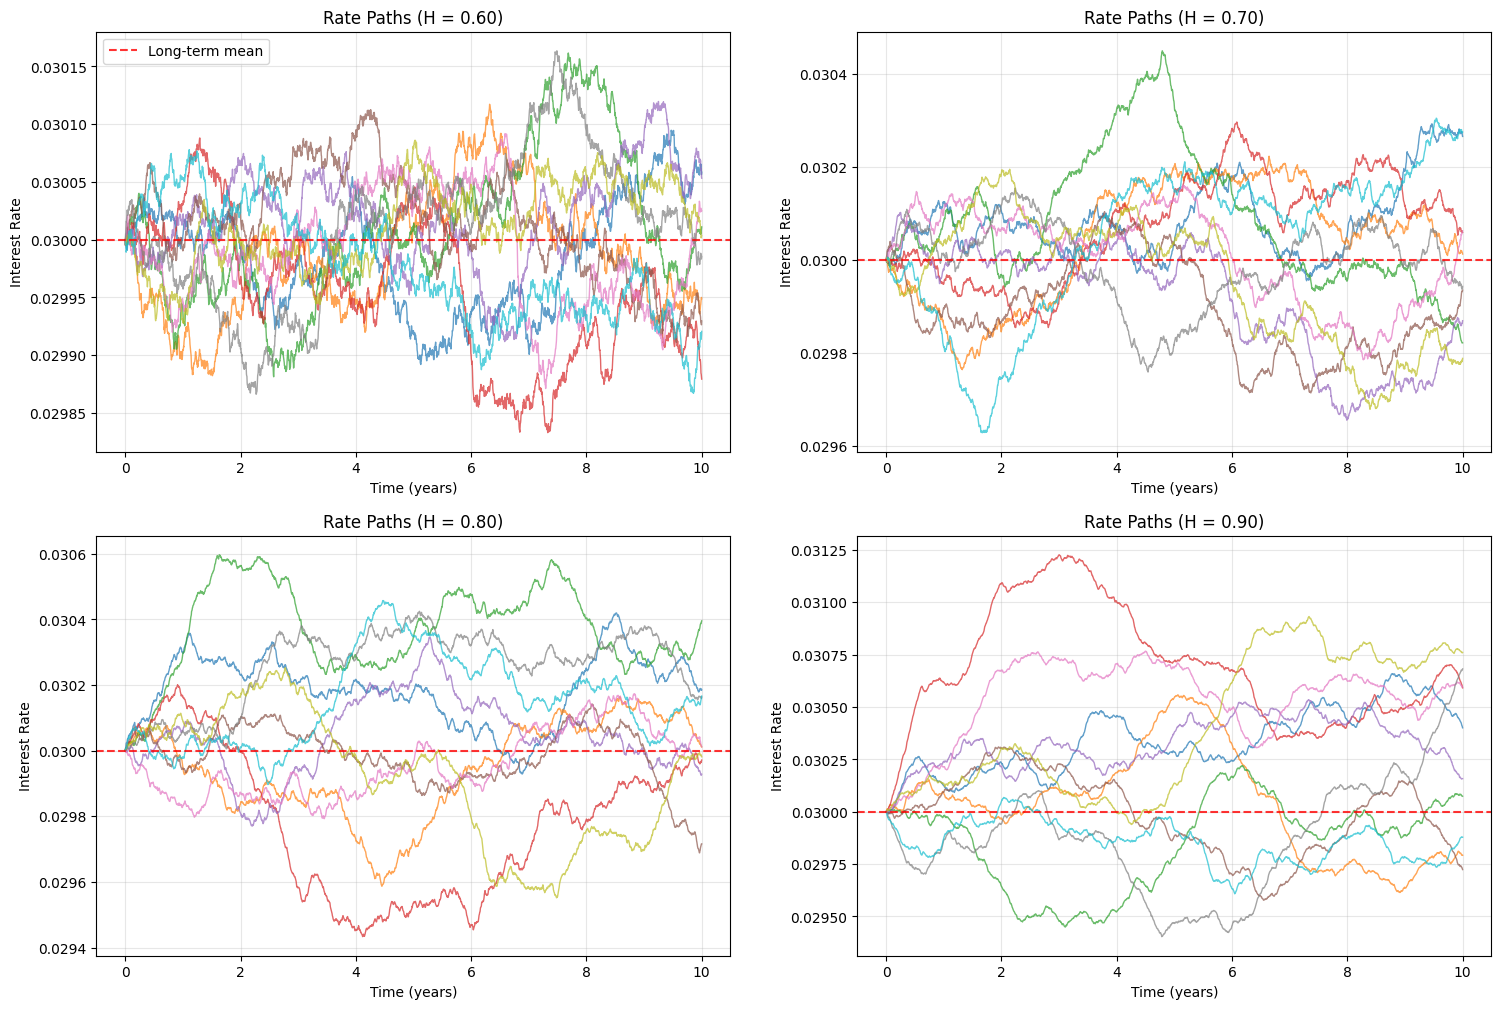

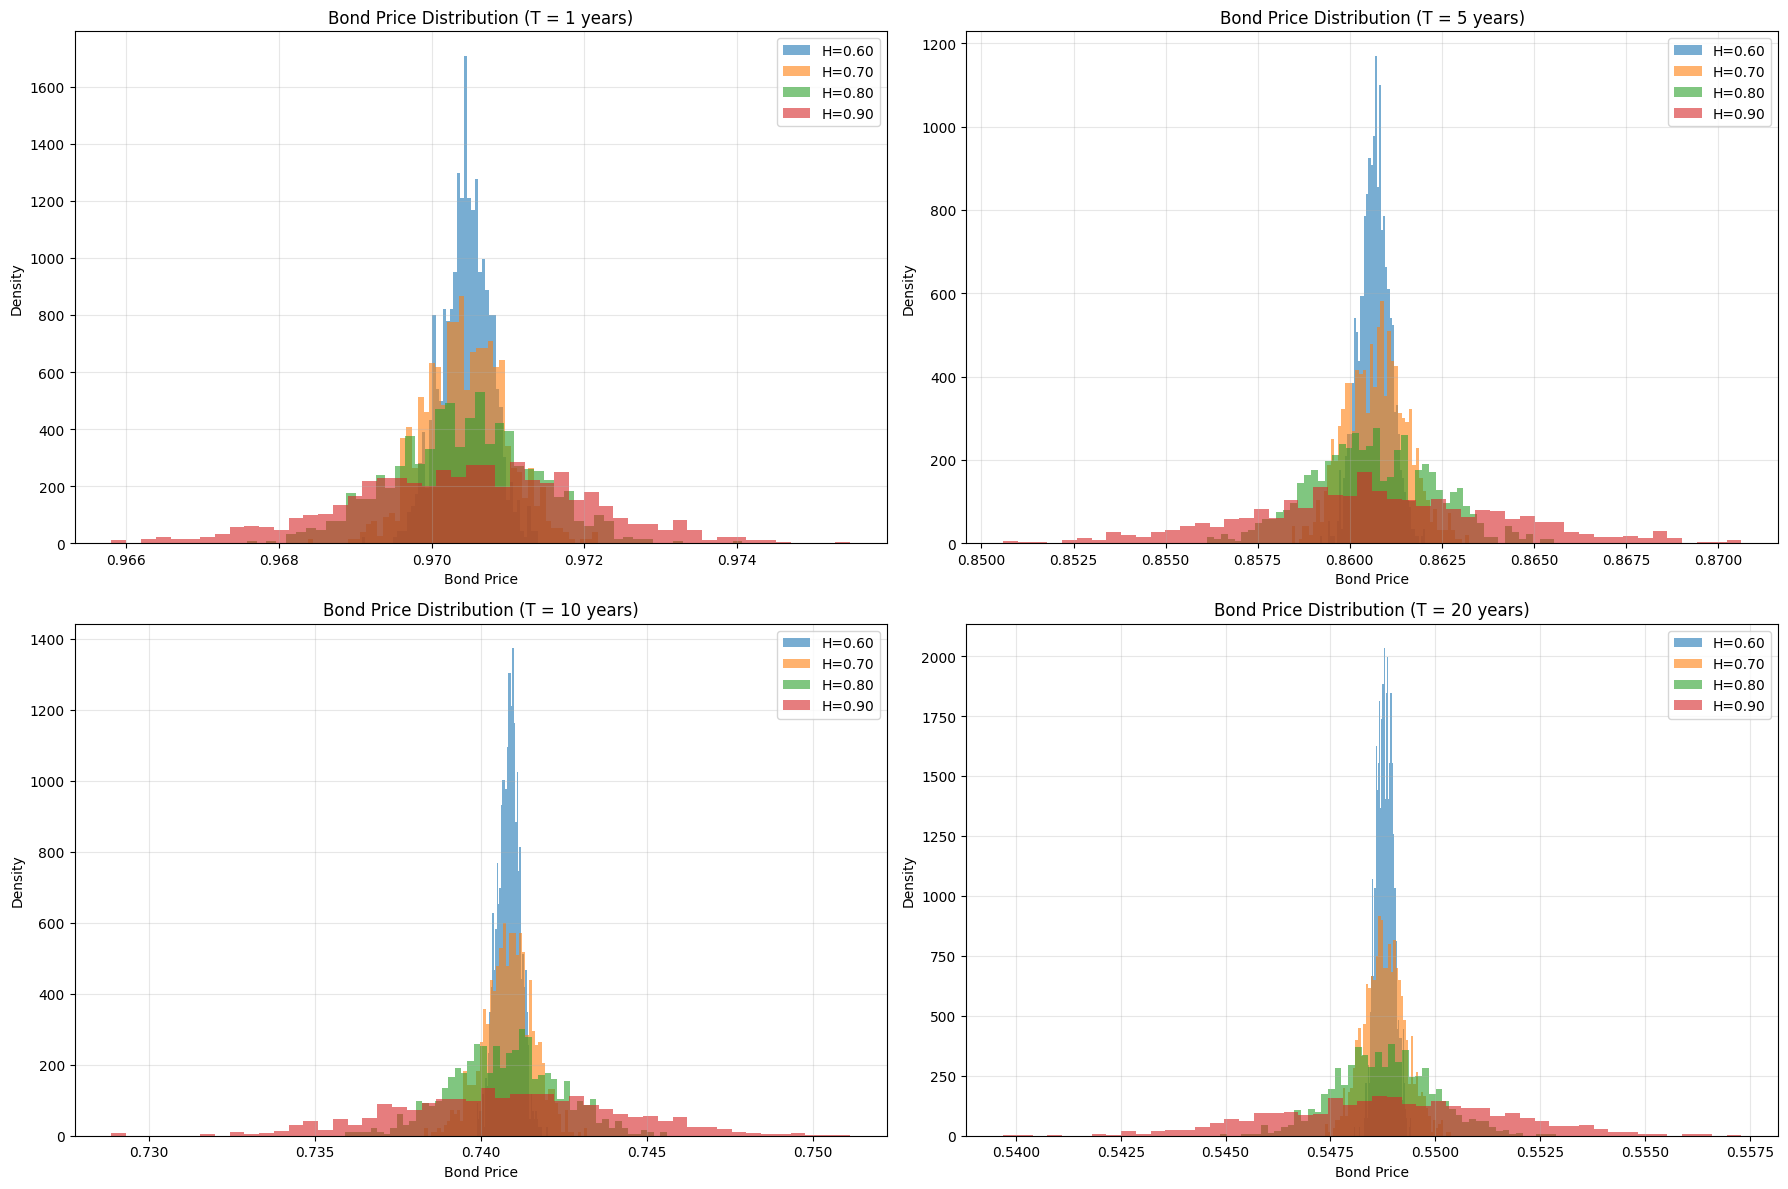

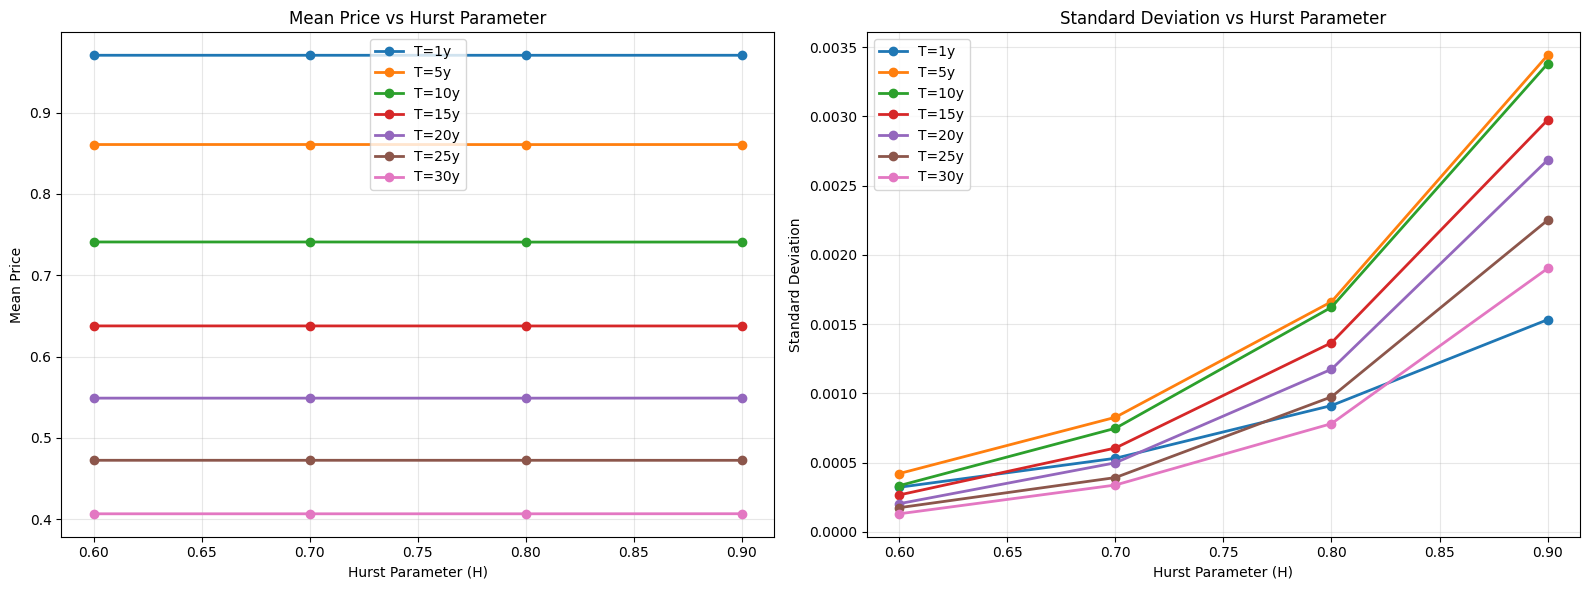

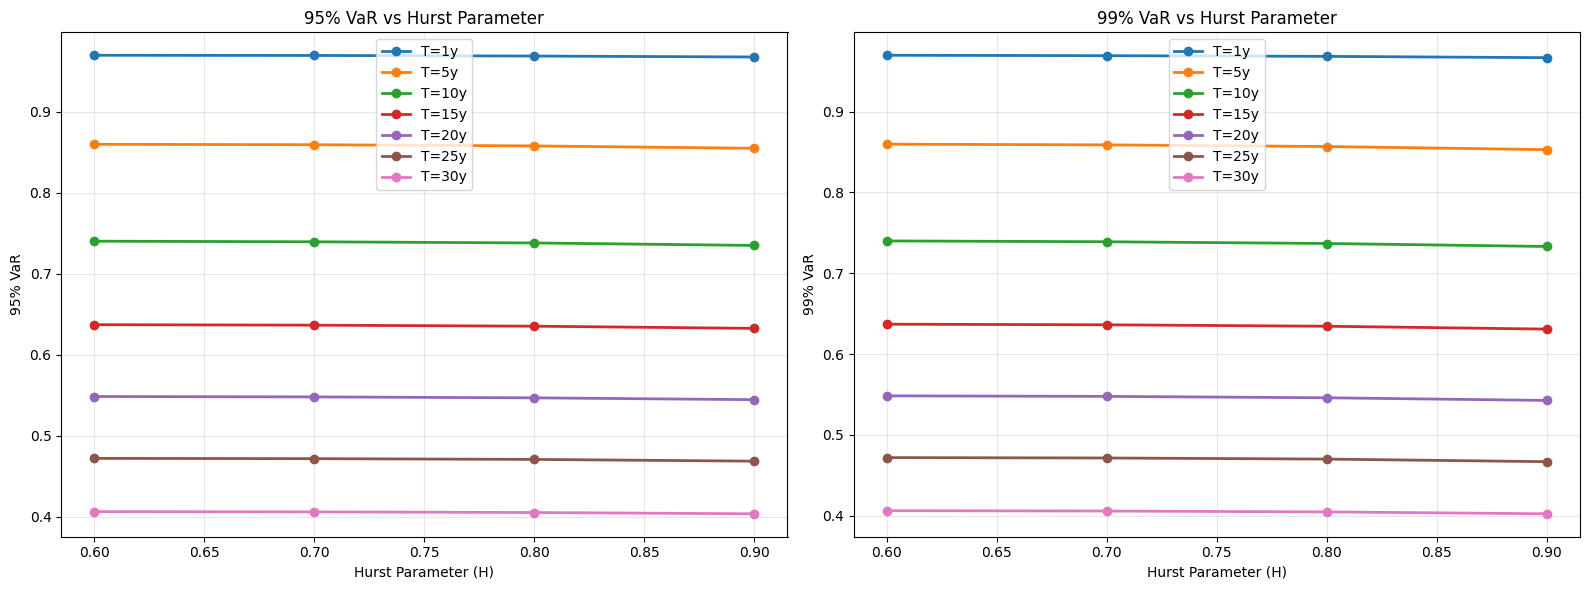


SUMMARY TABLE: BOND PRICING STATISTICS

Maturity: 1 years
------------------------------------------------------------
H      Mean     Std      Skew     Kurt     VaR95    VaR99   
------------------------------------------------------------
0.60   0.9705   0.0003   -0.128   0.177    0.9699   0.9697  
0.70   0.9704   0.0005   0.074    0.142    0.9696   0.9692  
0.80   0.9704   0.0009   0.010    -0.016   0.9689   0.9684  
0.90   0.9704   0.0015   -0.106   -0.042   0.9678   0.9667  

Maturity: 5 years
------------------------------------------------------------
H      Mean     Std      Skew     Kurt     VaR95    VaR99   
------------------------------------------------------------
0.60   0.8607   0.0004   -0.016   0.123    0.8600   0.8597  
0.70   0.8607   0.0008   0.064    -0.207   0.8594   0.8589  
0.80   0.8606   0.0017   0.093    -0.208   0.8579   0.8568  
0.90   0.8607   0.0034   0.047    -0.053   0.8550   0.8530  

Maturity: 10 years
------------------------------------------------

In [2]:
def main():
    """
    Main execution function
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Run comprehensive analysis
    results = comprehensive_analysis(hurst_values=[0.6, 0.7, 0.8, 0.9], maturities=[1, 5, 10, 15, 20, 25, 30])
    
    # Generate visualizations
    create_comprehensive_plots(results, hurst_values=[0.6, 0.7, 0.8, 0.9], maturities=[1, 5, 10, 20])
    plot_mean_std_vs_hurst(results, hurst_values=[0.6, 0.7, 0.8, 0.9], maturities=[1, 5, 10, 15, 20, 25, 30])
    plot_VaR_vs_hurst(results, hurst_values=[0.6, 0.7, 0.8, 0.9], maturities=[1, 5, 10, 15, 20, 25, 30])
    
    # Generate summary statistics
    generate_summary_table(results)
    
    print("\nAnalysis completed successfully!")
    
    return results

if __name__ == "__main__":
    results = main()

## 4.3 Forward Rate Agreement Pricing

## 4.4 Cap and Floor Pricing